### Importing

In [34]:
# pip install -r ../python_requirements.txt

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
import requests
import time
import io

from sklearn.model_selection import cross_val_score
from sklearn.decomposition import PCA
from sklearn.model_selection import KFold
from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score, classification_report, precision_recall_fscore_support, f1_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import scale

In [36]:
np.seterr(all='raise')

{'divide': 'raise', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

## Stochasticity in the Data Split

As seen in (02 - Classifer), we mentioned the improved performance of our Random Forest classifier on the second split of the data when we used the `KFold(n_splits=2)` function with `Shuffle` argument left to the default value of False.

We explore this in more detail here by observing our classifier's performance on both seen and unseen attacks, starting with 'land' attacks below:

In [19]:
read_file = pd.read_csv('kdd_log_df.csv')
kdd_log_df = pd.DataFrame(read_file)

read_file = pd.read_csv('kdd_df.csv')
kdd_df = pd.DataFrame(read_file)

In [5]:
cols = kdd_log_df.columns

features = kdd_log_df[cols[:-2]].copy()
target = kdd_log_df[cols[-1]].copy()
target = target.apply(lambda x: x if 'normal' in x else 'attack')

In [6]:
start = time.time()

X = features.copy()
y = target.copy()

kf = KFold(n_splits=2)

atk = kdd_log_df.connection_type=='land'
non_atk = kdd_log_df.connection_type!='land'

X_non_atk = X[non_atk]
X_atk = X[atk]
y_non_atk = y[non_atk]
y_atk = y[atk]


for train_index, test_index in kf.split(X_non_atk):
    X_train, X_test = X_non_atk.iloc[train_index], X_non_atk.iloc[test_index]
    y_train, y_test = y_non_atk.iloc[train_index], y_non_atk.iloc[test_index]
    
    rdF = RandomForestClassifier(n_estimators=100, max_depth=50,random_state=45)
    rdF.fit(X_train,y_train)

    pred = rdF.predict(X_test)
    kappa = float(cohen_kappa_score(y_test, pred))

    pred_new = rdF.predict(X_atk)
    accuracy_new = float(accuracy_score(y_atk,pred_new))

    print('Cohen-Kappa-Score (known attacks): %.3f' % kappa)
    print('Accuracy (unknown land attacks): %.3f' % accuracy_new)
    print('Total score: %.3f' % (0.5*(kappa+accuracy_new)))
    print()
    print('---')
    print()
    
    
end = time.time()

print('Time elapsed: %.2f seconds.' % (end-start))

Cohen-Kappa-Score (known attacks): 0.987
Accuracy (unknown land attacks): 0.286
Total score: 0.636

---

Cohen-Kappa-Score (known attacks): 0.998
Accuracy (unknown land attacks): 1.000
Total score: 0.999

---

Time elapsed: 28.61 seconds.


The increase in prediction accuracy is clearly significant. We explore the two data splits to see if there is any overlap between the two splits.

In [7]:
splits2 = [(train,test) for train,test in kf.split(X_non_atk)]
splits2

[(array([247000, 247001, 247002, ..., 493997, 493998, 493999]),
  array([     0,      1,      2, ..., 246997, 246998, 246999])),
 (array([     0,      1,      2, ..., 246997, 246998, 246999]),
  array([247000, 247001, 247002, ..., 493997, 493998, 493999]))]

In [8]:
start=time.time()

for a in splits2[0][0]:
    if a in splits2[1][0]:
        #index a should be printed for each a where there is an overlap between the two training sets
        print(a)
        
end=time.time()
print('Done. Time elapsed %.2f seconds.' %(end-start))

Done. Time elapsed 32.92 seconds.


We now explore what happens when we change the number of folds, k, to be equal to 4.

In [9]:
start = time.time()

X = features.copy()
y = target.copy()

kf = KFold(n_splits=4)

atk = kdd_log_df.connection_type=='land'
non_atk = kdd_log_df.connection_type!='land'

X_non_atk = X[non_atk]
X_atk = X[atk]
y_non_atk = y[non_atk]
y_atk = y[atk]

for train_index, test_index in kf.split(X_non_atk):
    X_train, X_test = X_non_atk.iloc[train_index], X_non_atk.iloc[test_index]
    y_train, y_test = y_non_atk.iloc[train_index], y_non_atk.iloc[test_index]
    
    rdF = RandomForestClassifier(n_estimators=100, max_depth=50,random_state=45)
    rdF.fit(X_train,y_train)

    pred = rdF.predict(X_test)
    kappa = float(cohen_kappa_score(y_test, pred))
    
    pred_new = rdF.predict(X_atk)
    accuracy_new = float(accuracy_score(y_atk,pred_new))

    print('Model:',rdF)
    print()
    

    print('Cohen-Kappa-Score (known attacks): %.3f' % kappa)
    print('Accuracy (unknown land attacks): %.3f' % accuracy_new)
    print('Total score: %.3f' % (0.5*(kappa+accuracy_new)))
    print()
    print('---')
    print()
    
    
end = time.time()

print('Time elapsed: %.2f seconds.' % (end-start))

Model: RandomForestClassifier(max_depth=50, random_state=45)

Cohen-Kappa-Score (known attacks): 0.980
Accuracy (unknown land attacks): 0.333
Total score: 0.657

---

Model: RandomForestClassifier(max_depth=50, random_state=45)

Cohen-Kappa-Score (known attacks): 0.948
Accuracy (unknown land attacks): 0.286
Total score: 0.617

---

Model: RandomForestClassifier(max_depth=50, random_state=45)

Cohen-Kappa-Score (known attacks): 0.999
Accuracy (unknown land attacks): 1.000
Total score: 1.000

---

Model: RandomForestClassifier(max_depth=50, random_state=45)

Cohen-Kappa-Score (known attacks): 1.000
Accuracy (unknown land attacks): 0.333
Total score: 0.666

---

Time elapsed: 79.78 seconds.


Again, we see a split that results in 100% accuracy in catching 'land' attacks so we try to compare this split for 4 folds with the initial split that we had for 2 folds. 

We will also explore the other 2 splits where there was a slight increase in accuracy.

In [10]:
splits4 = [(train,test) for train,test in kf.split(X_non_atk)]
splits4

[(array([123500, 123501, 123502, ..., 493997, 493998, 493999]),
  array([     0,      1,      2, ..., 123497, 123498, 123499])),
 (array([     0,      1,      2, ..., 493997, 493998, 493999]),
  array([123500, 123501, 123502, ..., 246997, 246998, 246999])),
 (array([     0,      1,      2, ..., 493997, 493998, 493999]),
  array([247000, 247001, 247002, ..., 370497, 370498, 370499])),
 (array([     0,      1,      2, ..., 370497, 370498, 370499]),
  array([370500, 370501, 370502, ..., 493997, 493998, 493999]))]

In [11]:
start = time.time()

#this is the split that had accuracy 1.0 for k=4
ser = [a for a in splits4[2][0] if a in splits2[1][0]]

print('Number of overlapping observations: {:,}.'.format(len(ser)))
print('Length of split for k=2: {:,}, length of split for k=4: {:,}'.format(len(splits2[1][0]),len(splits4[2][0])))
        
end=time.time()
print('Done. Time elapsed: %.2f seconds' %(end-start))

Number of overlapping observations: 247,000.
Length of split for k=2: 247,000, length of split for k=4: 370,500
Done. Time elapsed: 51.37 seconds


The split in k=4 that returns an accuracy of 1.00 contains the entirety of the initial split in k=2 that returned the same accuracy and so we can more confidently say that the data is not ordered randomly and that the first half of the data contains significant information which affects our model's prediction of some unseen attacks, in this case 'land' attacks.

In [100]:
start = time.time()

#this is the split that had accuracy 0.333 for k=4
ser = [a for a in splits4[0][0] if a in splits2[1][0]]

print('Number of overlapping observations: {:,}.'.format(len(ser)))
print('Length of split for k=2: {:,}, length of split for k=4: {:,}'.format(len(splits2[1][0]),len(splits4[2][0])))
        
end=time.time()
print('Done. Time elapsed: %.2f seconds' %(end-start))

Number of overlapping observations: 123,500.
Length of split for k=2: 247,000, length of split for k=4: 370,500
Done. Time elapsed: 53.43 seconds


We explore how this relationship evolves as k increases:

In [39]:
# this code runs fine but it just takes time so I interrupted it as the relevant results below it can still be seen
# you should be able to run this without errors
start = time.time()

X = features.copy()
y = target.copy()


atk = kdd_log_df.connection_type=='land'
non_atk = kdd_log_df.connection_type!='land'

X_non_atk = X[non_atk]
X_atk = X[atk]
y_non_atk = y[non_atk]
y_atk = y[atk]

fold_score=[]

for k in range(2,21,2):
    kf = KFold(n_splits=k)
    i=1
    
    print('Training on %.0f folds' %  k)
    scores=[]
    for train_index, test_index in kf.split(X_non_atk):
        X_train, X_test = X_non_atk.iloc[train_index], X_non_atk.iloc[test_index]
        y_train, y_test = y_non_atk.iloc[train_index], y_non_atk.iloc[test_index]

        rdF = RandomForestClassifier(n_estimators=100, max_depth=50,random_state=45)
        rdF.fit(X_train,y_train)

        pred = rdF.predict(X_test)
        try:
            kappa = float(cohen_kappa_score(y_test, pred))
        except:
            kappa = float(1)

        pred_new = rdF.predict(X_atk)
        accuracy_new = float(accuracy_score(y_atk,pred_new))
        
        
        score = (0.5*(kappa+accuracy_new))
        scores.append(score)

        print('   Split number %.0f'%i)
        print('      Cohen-Kappa-Score (known attacks): %.3f' % kappa)
        print('      Accuracy (unknown land attacks): %.3f' % accuracy_new)
        print('      Total score: %.3f' % score)
        print('      ---')
        print()
        i+=1
        
    avg_score = np.mean(scores)
    std_score = np.std(scores)
    print('----Average performance for %.0f folds: %.3f (%.3f)----' % (k,avg_score,std_score))
    
    fold_score.append((k,avg_score,std_score))
    
end = time.time()
print('Time elapsed %.2f seconds' % (end-start))

Training on 2 folds
   Split number 1
      Cohen-Kappa-Score (known attacks): 0.987
      Accuracy (unknown land attacks): 0.286
      Total score: 0.636
      ---

   Split number 2
      Cohen-Kappa-Score (known attacks): 0.998
      Accuracy (unknown land attacks): 1.000
      Total score: 0.999
      ---

----Average performance for 2 folds: 0.818 (0.181)----
Training on 4 folds
   Split number 1
      Cohen-Kappa-Score (known attacks): 0.980
      Accuracy (unknown land attacks): 0.333
      Total score: 0.657
      ---

   Split number 2
      Cohen-Kappa-Score (known attacks): 0.948
      Accuracy (unknown land attacks): 0.286
      Total score: 0.617
      ---

   Split number 3
      Cohen-Kappa-Score (known attacks): 0.999
      Accuracy (unknown land attacks): 1.000
      Total score: 1.000
      ---

   Split number 4
      Cohen-Kappa-Score (known attacks): 1.000
      Accuracy (unknown land attacks): 0.333
      Total score: 0.666
      ---

----Average performance for 4

KeyboardInterrupt: 

In [15]:
fold_score

[(2, 0.8176291035161828, 0.18125706566274158),
 (4, 0.7348545775733277, 0.15395110768105597),
 (6, 0.7032517624850151, 0.13480295784986485),
 (8, 0.7219738355964223, 0.11921286623372472),
 (10, 0.7164137820393974, 0.10064459033594408),
 (12, 0.8279783604736695, 0.10611947446623543),
 (14, 0.7460200468812995, 0.1266291161415719),
 (16, 0.702629283707999, 0.0776048504856278),
 (18, 0.7085963248778943, 0.09983512073127226),
 (20, 0.8000090332958056, 0.10008027845802363)]

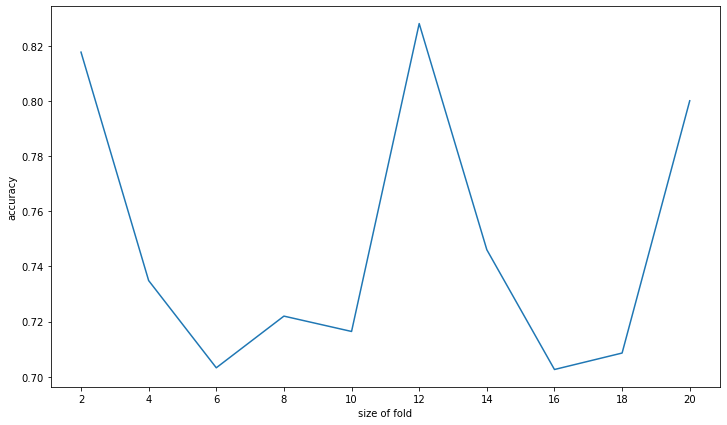

In [16]:
fig = plt.figure(figsize=(12,7))

x = [t[0] for t in fold_score]
y = [t[1] for t in fold_score]
plt.xlabel('size of fold')
plt.ylabel('accuracy')
plt.xticks(list(range(2,21,2)))
plt.plot(x,y)

It seems that a particular split of the data somehow captures some information which drastically improves prediction for 'unseen' land attacks. This isn't entirely clear why. At first we thought this was a bug as it happened consistently (see below where the above processes was iterated to remove each type of attack one at a time and predict accordingly).

In [16]:
train_index

array([106616, 106617, 106618, ..., 213228, 213229, 213230])

In [17]:
test_index

array([     0,      1,      2, ..., 106613, 106614, 106615])

In [21]:
X = features.copy()
y = target.copy()

attacks = [attack for attack in kdd_df.connection_type.value_counts().index]
start = time.time()

kf = KFold(n_splits = 2)

for attack in attacks:
    if attack=='normal':
        pass
    else:
        non_atk = kdd_df.connection_type!=attack 
        atk = kdd_df.connection_type==attack

        print('--------','Performance on removing',attack,'attacks','--------')
        X_non_atk = features[non_atk].copy()
        X_atk = features[atk].copy()
        y_non_atk = target[non_atk].copy()
        y_atk = target[atk].copy()
        
        for train_index, test_index in kf.split(X_non_atk):
            X_train, X_test = X_non_atk.iloc[train_index], X_non_atk.iloc[test_index]
            #an error occured here in the last minute of working on this project
            #pandas was no longer accepting the old indexing of y_non_atk[train_index]
            #having changed the format to y_non_atk.iloc[train_index], the whole set of results also changed
            y_train, y_test = y_non_atk.iloc[train_index], y_non_atk.iloc[test_index]

            rdF = RandomForestClassifier(n_estimators=100, max_depth=50,random_state=45)
            rdF.fit(X_train,y_train)

            pred = rdF.predict(X_test)
            cm = confusion_matrix(y_test, pred)

            pred_new = rdF.predict(X_atk)
            accuracy_new = accuracy_score(y_atk,pred_new)
            cm_new =confusion_matrix(y_atk, pred_new)


            print('Model:',rdF)
            print()
            print('Accuracy (unknown',attack,'attacks:',accuracy_new)
            print()

            print('Classification report (known attacks):')
            print((classification_report(y_test,pred, labels=None)))
            print()

            print('Cohen Kappa Score (known attacks):',cohen_kappa_score(y_test, pred))
            print()

            print('Confusion Matrix (known attacks):')
            print(cm)
            print()
            print('Confusion Matrix (unknown',attack,'attacks):')
            print(cm_new)    
            print()



            print('---')


end = time.time()

print()
print('Time elapsed:',end-start,'seconds')

-------- Performance on removing smurf attacks --------
Model: RandomForestClassifier(max_depth=50, random_state=45)

Accuracy (unknown smurf attacks: 4.2736564692474806e-05

Classification report (known attacks):
              precision    recall  f1-score   support

      attack       1.00      1.00      1.00     45321
      normal       1.00      1.00      1.00     61295

    accuracy                           1.00    106616
   macro avg       1.00      1.00      1.00    106616
weighted avg       1.00      1.00      1.00    106616


Cohen Kappa Score (known attacks): 0.9954684721348632

Confusion Matrix (known attacks):
[[45097   224]
 [   12 61283]]

Confusion Matrix (unknown smurf attacks):
[[    12 280778]
 [     0      0]]

---
Model: RandomForestClassifier(max_depth=50, random_state=45)

Accuracy (unknown smurf attacks: 0.00012108693329534528

Classification report (known attacks):
              precision    recall  f1-score   support

      attack       0.98      0.98      0.9

Cohen Kappa Score (known attacks): 0.9980070315433464

Confusion Matrix (known attacks):
[[220349     88]
 [     5  26048]]

Confusion Matrix (unknown portsweep attacks):
[[1022   18]
 [   0    0]]

---
-------- Performance on removing warezclient attacks --------
Model: RandomForestClassifier(max_depth=50, random_state=45)

Accuracy (unknown warezclient attacks: 0.0

Classification report (known attacks):
              precision    recall  f1-score   support

      attack       1.00      1.00      1.00    175276
      normal       1.00      1.00      1.00     71225

    accuracy                           1.00    246501
   macro avg       1.00      1.00      1.00    246501
weighted avg       1.00      1.00      1.00    246501


Cohen Kappa Score (known attacks): 0.9970220088092748

Confusion Matrix (known attacks):
[[174982    294]
 [     8  71217]]

Confusion Matrix (unknown warezclient attacks):
[[   0 1020]
 [   0    0]]

---
Model: RandomForestClassifier(max_depth=50, random_state=

KeyboardInterrupt: 

The results above changed after pandas stopped accepting the old indexing method for the target variables y_train and y_test. Having changed the indexing, the entire set of results also changed which means that either this set of new results is due to a bug or the somehow the old set of results were a bug.

Due to lack of time, we take the old set of results to be true and fortunately we had saved a string of the printed results which we show below.

In [38]:
with open('../text_data/original_string.txt', 'r') as file:
    orig_str = file.read()
    
print(orig_str)

a = '''-------- Performance on removing smurf attacks --------
Model: RandomForestClassifier(max_depth=50, n_estimators=250, random_state=45)

Accuracy (known attacks): 0.9837641629774143
Accuracy (unknown smurf attacks: 1.0

Classification report (known attacks):
              precision    recall  f1-score   support

  non-normal       1.00      0.96      0.98     47413
      normal       0.97      1.00      0.99     59203

    accuracy                           0.98    106616
   macro avg       0.99      0.98      0.98    106616
weighted avg       0.98      0.98      0.98    106616


Cohen Kappa Score (known attacks): 0.9670091611682816

Confusion Matrix (known attacks):
[[45702  1711]
 [   20 59183]]

Confusion Matrix (unknown smurf attacks):
[[280790]]

---
Model: RandomForestClassifier(max_depth=50, n_estimators=250, random_state=45)

Accuracy (known attacks): 0.9893073207334803
Accuracy (unknown smurf attacks: 0.999996438619609

Classification report (known attacks):
            

## Using train_test_split 1-fold CV

In [23]:
m=0.01
i=0
while m<1:
    print(str(i)+':',m)
    m = round(m*1.5,3)
    i+=1

0: 0.01
1: 0.015
2: 0.022
3: 0.033
4: 0.05
5: 0.075
6: 0.112
7: 0.168
8: 0.252
9: 0.378
10: 0.567
11: 0.85


As the number of folds k increased above, the training size increased (k-1)/k. We now use the train_test_split() function from scikitlearn to slowly increase the training set size while shuffling the data and see how this affects our performance.

In [29]:
start = time.time()

X = features.copy()
y = target.copy()


atk = kdd_log_df.connection_type=='land'
non_atk = kdd_log_df.connection_type!='land'

X_non_atk = X[non_atk]
X_atk = X[atk]
y_non_atk = y[non_atk]
y_atk = y[atk]

size_score=[]
m=0.01

while m < 1:
    
    X_train,X_test,y_train,y_test = train_test_split(X_non_atk,y_non_atk, 
                                                    train_size=m,
                                                    shuffle=True,random_state=42) 
    
    print('Training on training set size:', m)
    rdF = RandomForestClassifier(n_estimators=100, max_depth=50,random_state=45)
    rdF.fit(X_train,y_train)
    pred = rdF.predict(X_test)
    try:
        kappa = float(cohen_kappa_score(y_test, pred))
    except:
        kappa = float(1)

    pred_new = rdF.predict(X_atk)
    accuracy_new = float(accuracy_score(y_atk,pred_new))

    score = (0.5*(kappa+accuracy_new))
    size_score.append((m,score))

    print('      Cohen-Kappa-Score (known attacks): %.3f' % kappa)
    print('      Accuracy (unknown land attacks): %.3f' % accuracy_new)
    print('      Total score: %.3f' % score)
    print('      ---')
    print()
    
    #increase size of n so we have 12 iterations
    m = round(m*1.5,3)
 
end = time.time()
print('Time elapsed %.2f seconds' % (end-start))

Training on training set size: 0.01
      Cohen-Kappa-Score (known attacks): 0.997
      Accuracy (unknown land attacks): 1.000
      Total score: 0.999
      ---

Training on training set size: 0.015
      Cohen-Kappa-Score (known attacks): 0.997
      Accuracy (unknown land attacks): 1.000
      Total score: 0.999
      ---

Training on training set size: 0.022
      Cohen-Kappa-Score (known attacks): 0.998
      Accuracy (unknown land attacks): 1.000
      Total score: 0.999
      ---

Training on training set size: 0.033
      Cohen-Kappa-Score (known attacks): 0.998
      Accuracy (unknown land attacks): 1.000
      Total score: 0.999
      ---

Training on training set size: 0.05
      Cohen-Kappa-Score (known attacks): 0.998
      Accuracy (unknown land attacks): 1.000
      Total score: 0.999
      ---

Training on training set size: 0.075
      Cohen-Kappa-Score (known attacks): 0.998
      Accuracy (unknown land attacks): 1.000
      Total score: 0.999
      ---

Training on 

In [30]:
size_score

[(0.01, 0.998588918614951),
 (0.015, 0.9987476513460144),
 (0.022, 0.998774017232323),
 (0.033, 0.9988097424193991),
 (0.05, 0.9989766969466691),
 (0.075, 0.9990761535954862),
 (0.112, 0.6421038410854525),
 (0.168, 0.6660740535577782),
 (0.252, 0.6185894894786499),
 (0.378, 0.666228276195777),
 (0.567, 0.6663935828674177),
 (0.85, 0.6664521385793172)]

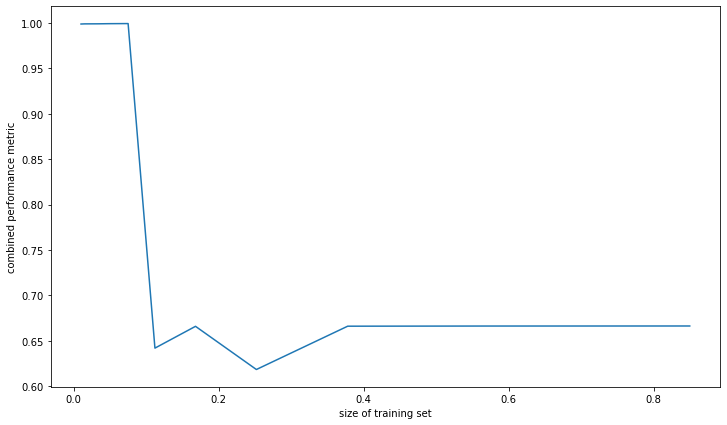

In [33]:
fig = plt.figure(figsize=(12,7))

x=[t[0] for t in size_score]
y=[t[1] for t in size_score]

plt.xlabel('size of training set')
plt.ylabel('combined performance metric')

plt.plot(x,y)

Surprisingly, on a small training set size the model seems to perform extremely well in identifying unseen land attacks and becomes worse with increasing size before plateauing. I would've liked to explore this a bit more with every single attack to see if the same result holds true and then perform a comparison of a Random Forest trained using this method vs another method.

In [27]:
start = time.time()

X = features.copy()
y = target.copy()

for attack in attacks:
    if attack=='normal':
        pass
    else:
        atk = kdd_log_df.connection_type==attack
        non_atk = kdd_log_df.connection_type!=attack

        X_non_atk = X[non_atk]
        X_atk = X[atk]
        y_non_atk = y[non_atk]
        y_atk = y[atk]
        
        print('---Training on removing {} attacks---'.format(attack))

        X_train,X_test,y_train,y_test = train_test_split(X_non_atk, y_non_atk, 
                                                        train_size=0.6,
                                                        shuffle=True, random_state=42) 
        
        rdF = RandomForestClassifier(n_estimators=100, max_depth=50,random_state=45)
        rdF.fit(X_train,y_train)

        
        pred = rdF.predict(X_test)
        try:
            kappa = float(cohen_kappa_score(y_test, pred))
        except:
            kappa = float(1)
#         cm = confusion_matrix(y_test, pred)


        pred_new = rdF.predict(X_atk)
        accuracy_new = float(accuracy_score(y_atk,pred_new))
#         cm_new =confusion_matrix(y_atk, pred_new)

        score = (0.5*(kappa+accuracy_new))
        size_score.append((m,score))

        print('      Cohen-Kappa-Score (known attacks): %.3f' % kappa)
#         print('      Confusion matrix (known attacks):')
#         print(cm)
#         print()
        print('      Accuracy (unknown {} attacks): {:.3f}'.format(attack,accuracy_new))
#         print('      Confusion matrix (unknown attacks):')
#         print(cm_new)
        print('      Total score: %.3f' % score)
        print('      ---')
        print()


end = time.time()
print('Time elapsed %.2f seconds' % (end-start))

---Training on removing smurf attacks---
      Cohen-Kappa-Score (known attacks): 0.999
      Accuracy (unknown smurf attacks): 0.000
      Total score: 0.500
      ---

---Training on removing neptune attacks---
      Cohen-Kappa-Score (known attacks): 0.999
      Accuracy (unknown neptune attacks): 0.999
      Total score: 0.999
      ---

---Training on removing back attacks---
      Cohen-Kappa-Score (known attacks): 0.999
      Accuracy (unknown back attacks): 0.000
      Total score: 0.500
      ---

---Training on removing satan attacks---
      Cohen-Kappa-Score (known attacks): 1.000
      Accuracy (unknown satan attacks): 0.972
      Total score: 0.986
      ---

---Training on removing ipsweep attacks---
      Cohen-Kappa-Score (known attacks): 0.999
      Accuracy (unknown ipsweep attacks): 0.959
      Total score: 0.979
      ---

---Training on removing portsweep attacks---
      Cohen-Kappa-Score (known attacks): 0.999
      Accuracy (unknown portsweep attacks): 0.993
  